<a href="https://colab.research.google.com/github/ztjfreedom/colab/blob/master/keras_lstm_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB movie review sentiment classification with LSTM

In this notebook, we'll train a LSTM for sentiment classification using Keras (with either Theano or Tensorflow as the compute backend).  Keras version $\ge$ 2 is required. This notebook is largely based on the [Understanding recurrent neural networks](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb) by François Chollet.

First, the needed imports. Keras tells us which backend (Theano, Tensorflow, CNTK) it will be using.

In [1]:
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.layers import LSTM, CuDNNLSTM
from keras.datasets import imdb

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using TensorFlow backend.


Using Keras version: 2.2.4 backend: tensorflow


## IMDB data set

Next we'll load the IMDB data set. First time we may have to download the data, which can take a while.

The dataset contains 50000 movies reviews from the Internet Movie Database, split into 25000 reviews for training and 25000 reviews for testing. Half of the reviews are positive (1) and half are negative (0).

The dataset has already been preprocessed, and each word has been replaced by an integer index.
The reviews are thus represented as varying-length sequences of integers.
(Word indices begin at "3", as "1" is used to mark the start of a review and "2" represents all out-of-vocabulary words. "0" will be used later to pad shorter reviews to a fixed size.)

In [4]:
# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 80

print('Loading data...')

pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2
 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words, start_char=start_id,
                                                      oov_char=oov_id, index_from=index_offset)

print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen, truncating='post', padding='post', value=pad_id)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, truncating='post', padding='post', value=pad_id)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
x_train: (25000,)
x_test: (25000,)

Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)


The first movie review in the training set:

In [5]:
print("First review in the training set:\n", x_train[0], "length:", len(x_train[0]), "class:", y_train[0])

First review in the training set:
 [   1   13   21   15   42  529  972 1621 1384   64  457 4467   65 3940
    3  172   35  255    4   24   99   42  837  111   49  669    2    8
   34  479  283    4  149    3  171  111  166    2  335  384   38    3
  171 4535 1110   16  545   37   12  446    3  191   49   15    5  146
 2024   18   13   21    3 1919 4612  468    3   21   70   86   11   15
   42  529   37   75   14   12 1246    3   21   16] length: 80 class: 1


## Initialization

Let's create an RNN model that has one (or optionally two) LSTM layers. Dropout  The first layer in the network is an *Embedding* layer that converts integer indices to dense vectors of length `embedding_dims`. The output layer contains a single neuron and *sigmoid* non-linearity to match the binary groundtruth (`y_train`). 

Finally, we `compile()` the model, using *binary crossentropy* as the loss function and [*RMSprop*](https://keras.io/optimizers/#rmsprop) as the optimizer.

In [14]:
# model parameters:
embedding_dims = 50
lstm_units = 32

print('Build model...')
model = Sequential()

model.add(Embedding(nb_words,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# CPU ver:
#model.add(LSTM(lstm_units))
# GPU ver:
model.add(CuDNNLSTM(lstm_units))

# to stack multiple RNN layers, all RNN layers except the last one need
# to have "return_sequences=True".  An example of using two RNN layers:
#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(LSTM(lstm_units))

model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 50)            500000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 50)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 32)                10752     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 510,785
Trainable params: 510,785
Non-trainable params: 0
_________________________________________________________________
None


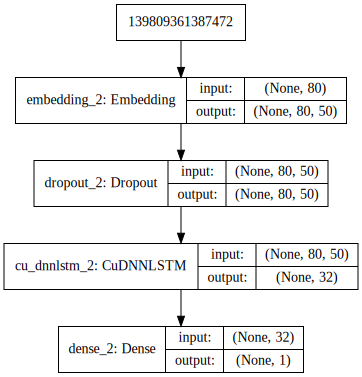

In [15]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Learning

Now we are ready to train our model.  An *epoch* means one pass through the whole training data. Note also that we are using a fraction of the training data as our validation set.

Note that LSTMs are rather slow to train.

In [16]:
%%time
epochs = 5
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 2s 87us/step - loss: 0.5611 - acc: 0.7018 - val_loss: 0.4550 - val_acc: 0.7854
Epoch 2/5
20000/20000 [==============================] - 1s 63us/step - loss: 0.3867 - acc: 0.8356 - val_loss: 0.4012 - val_acc: 0.8240
Epoch 3/5
20000/20000 [==============================] - 1s 61us/step - loss: 0.3269 - acc: 0.8654 - val_loss: 0.4152 - val_acc: 0.8106
Epoch 4/5
20000/20000 [==============================] - 1s 61us/step - loss: 0.2956 - acc: 0.8812 - val_loss: 0.4461 - val_acc: 0.8168
Epoch 5/5
20000/20000 [==============================] - 1s 62us/step - loss: 0.2715 - acc: 0.8932 - val_loss: 0.4521 - val_acc: 0.8164
CPU times: user 7.73 s, sys: 490 ms, total: 8.22 s
Wall time: 7.09 s


Let's plot the data to see how the training progressed. A big gap between training and validation accuracies would suggest overfitting.

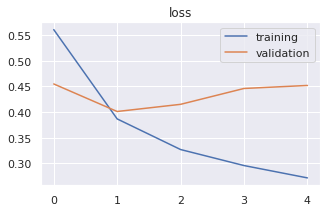

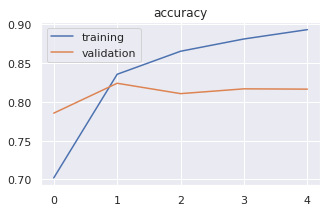

In [17]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'], label='training')
plt.plot(history.epoch,history.history['val_acc'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

## Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [18]:
scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 79.14%


---
*Run this notebook in Google Colaboratory using [this link](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-imdb-rnn.ipynb).*